C:\Users\AVISHEK\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\AVISHEK\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


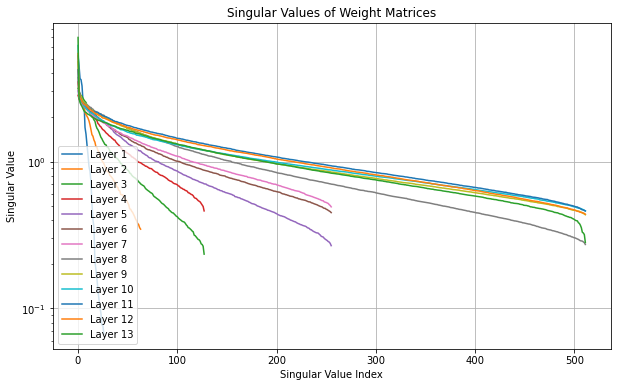

In [49]:
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt

class VGG16(nn.Module):
    def __init__(self, num_classes=1000):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
# Instantiate the VGG16 model
vgg16_model = VGG16()

# Load pre-trained weights from PyTorch's model zoo
vgg16_pretrained = models.vgg16(pretrained=True)
pretrained_dict = vgg16_pretrained.state_dict()

# Remove the "classifier" keys from the dictionary (they have different sizes)
classifier_keys = ['classifier.0.weight', 'classifier.0.bias',
                   'classifier.3.weight', 'classifier.3.bias',
                   'classifier.6.weight', 'classifier.6.bias']

for key in classifier_keys:
    del pretrained_dict[key]

# Load the modified state_dict into your model
vgg16_model.load_state_dict(pretrained_dict, strict=False)

# Set the model to evaluation mode
vgg16_model.eval()

# Function to extract pre-trained weight matrices
def extract_pretrained_weights(model):
    pretrained_weights = {}
    for name, param in model.named_parameters():
        if 'weight' in name and 'classifier' not in name:
            pretrained_weights[name] = param.data
    return pretrained_weights

# Extract pre-trained weight matrices
pretrained_weights = extract_pretrained_weights(vgg16_model)

def reshape_and_svd(weight_matrix):
    # Reshape the weight matrix to a 2D tensor
    reshaped_matrix = weight_matrix.view(weight_matrix.size(0), -1)
    
    # Perform Singular Value Decomposition (SVD)
    U, S, V = torch.svd(reshaped_matrix)
    
    return U, S, V

# List to store singular values for each weight matrix
singular_values_list = []

# Apply reshape_and_svd to each weight matrix and store singular values
for name, weight in pretrained_weights.items():
    U, S, V = reshape_and_svd(weight)
    singular_values_list.append(S.cpu().numpy())

# Plot singular values for each weight matrix
plt.figure(figsize=(10, 6))
for i, singular_values in enumerate(singular_values_list):
    plt.plot(singular_values, label=f'Layer {i+1}')
plt.yscale('log')
plt.xlabel('Singular Value Index')
plt.ylabel('Singular Value')
plt.title('Singular Values of Weight Matrices')
plt.legend()
plt.grid(True)
plt.show()
